MIT ECG 데이터 불러오기

hea파일에 있는 메타데이터 확인
- sampling rate

In [2]:
import wfdb
from collections import Counter

# MIT-BIH Arrhythmia Database record list
records = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

# Define the labels corresponding to each AAMI class
aami_classes = {
    'N': ['N', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q']
}

# Initialize counters for each AAMI class
aami_counters = {key: 0 for key in aami_classes}

# Process each record to count the labels according to AAMI classes
for record in records:
    annotation = wfdb.rdann(f'data/{record}', 'atr')
    for symbol in annotation.symbol:
        for aami_class, labels in aami_classes.items():
            if symbol in labels:
                aami_counters[aami_class] += 1

# Print the counts for each AAMI class
print("AAMI 클래스별 샘플 수:")
for aami_class, count in aami_counters.items():
    print(f"{aami_class}: {count}")

# Total number of samples in these AAMI classes
total_samples = sum(aami_counters.values())
print(f"\n전체 샘플 수: {total_samples}")


AAMI 클래스별 샘플 수:
N: 90631
S: 2781
V: 7236
F: 803
Q: 8043

전체 샘플 수: 109494


In [20]:
import wfdb

# MIT-BIH Arrhythmia Database record list
records = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

# Define the labels corresponding to each AAMI class
aami_classes = {
    'N': ['N', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q']
}

# Function to check if a record has all N, S, V, F, Q classes
def has_all_classes(annotation_symbols):
    found_classes = set()
    for symbol in annotation_symbols:
        for aami_class, labels in aami_classes.items():
            if symbol in labels:
                found_classes.add(aami_class)
    return len(found_classes) == len(aami_classes)

# List to store records that contain all N, S, V, F, Q classes
records_with_all_classes = []

# Process each record to check if it has all N, S, V, F, Q classes
for record in records:
    annotation = wfdb.rdann(f'data/{record}', 'atr')
    if has_all_classes(annotation.symbol):
        records_with_all_classes.append(record)

# Print the records that have all N, S, V, F, Q classes
print("N, S, V, F, Q 클래스를 모두 포함하는 레코드:")
print(records_with_all_classes)


N, S, V, F, Q 클래스를 모두 포함하는 레코드:
['203', '208']


In [31]:
import wfdb
import requests

# MIT-BIH 부정맥 데이터 레코드 URL

record_name = '208'

# 다운로드한 데이터 로드
record = wfdb.rdrecord(f'data/{record_name}')
annotation = wfdb.rdann(f'data/{record_name}', 'atr')



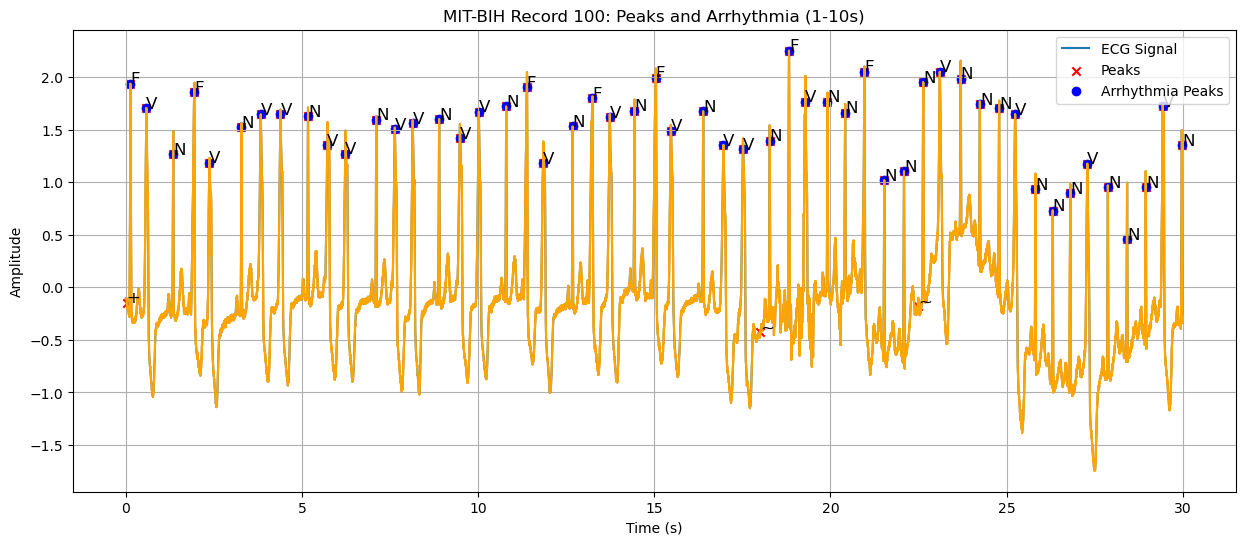

In [36]:
# 샘플링 주파수와 구간 설정
fs = record.fs
start_time = 0  # 1초
end_time = 30   # 10초
start_idx = int(start_time * fs)
end_idx = int(end_time * fs)


# 신호 구간 추출
signal_segment = record.p_signal[start_idx:end_idx, 0]  # 첫 번째 채널 사용
time_segment = np.arange(start_idx, end_idx) / fs

# 해당 구간의 피크와 주석 추출
peaks = [sample for sample in annotation.sample if start_idx <= sample < end_idx]
peak_times = [sample / fs for sample in peaks]
peak_annotations = [annotation.symbol[np.where(annotation.sample == sample)[0][0]] for sample in peaks]

# 부정맥 주석 기호 목록
arrhythmia_symbols = ['N', 'L', 'R', 'V', 'A', 'a', 'J', 'S', 'E', 'F', '/', 'f', 'Q']
arrhythmia_peaks = [time for time, symbol in zip(peak_times, peak_annotations) if symbol in arrhythmia_symbols]

# 신호 값과 시간 값을 일치시키기 위해 추가적인 처리
arrhythmia_signal_values = [signal_segment[int((time - start_time) * fs)] for time in arrhythmia_peaks]

# 그래프 시각화
plt.figure(figsize=(15, 6))
plt.plot(time_segment, signal_segment, label='ECG Signal')

# 피크 및 부정맥 주석 표시
plt.scatter(peak_times, signal_segment[[int((time - start_time) * fs) for time in peak_times]], color='red', marker='x', label='Peaks')
plt.scatter(arrhythmia_peaks, arrhythmia_signal_values, color='blue', marker='o', label='Arrhythmia Peaks')

# 주석 라벨 표시
for time, symbol in zip(peak_times, peak_annotations):
    plt.text(time, signal_segment[int((time - start_time) * fs)], symbol, color='black', fontsize=12)

# 부정맥 주석이 있는 구간 강조 표시
for arrhythmia_peak in arrhythmia_peaks:
    arrhythmia_start = max(int((arrhythmia_peak - 0.5) * fs), 0)
    arrhythmia_end = min(int((arrhythmia_peak + 0.5) * fs), len(signal_segment) + start_idx)
    arrhythmia_segment = record.p_signal[arrhythmia_start:arrhythmia_end, 0]
    arrhythmia_time = np.arange(arrhythmia_start, arrhythmia_end) / fs
    plt.plot(arrhythmia_time, arrhythmia_segment, color='orange')

plt.title('MIT-BIH Record 100: Peaks and Arrhythmia (1-10s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

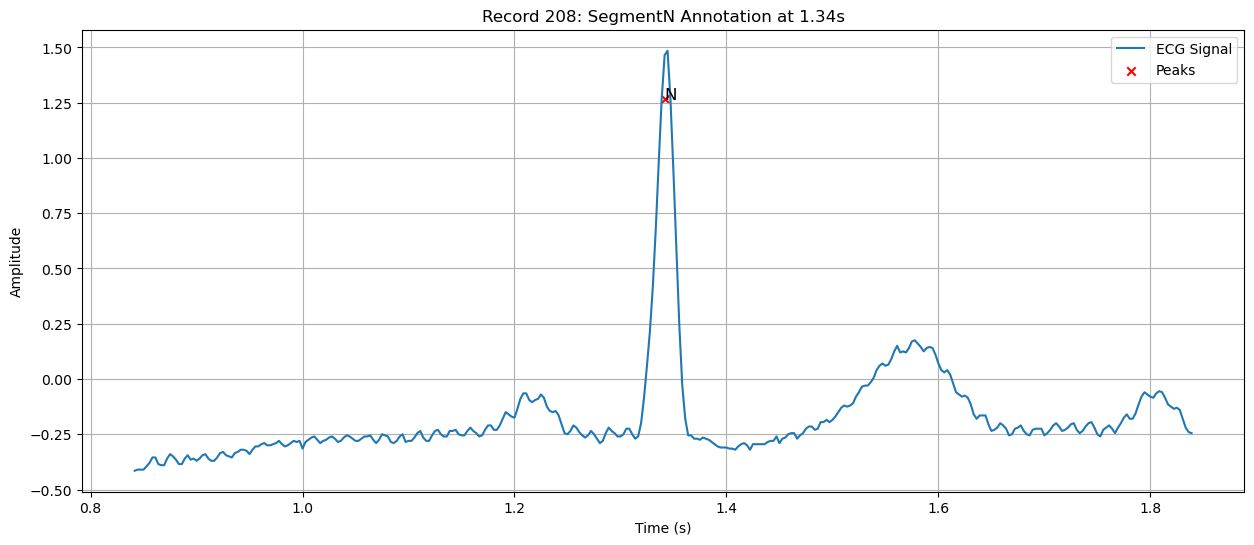

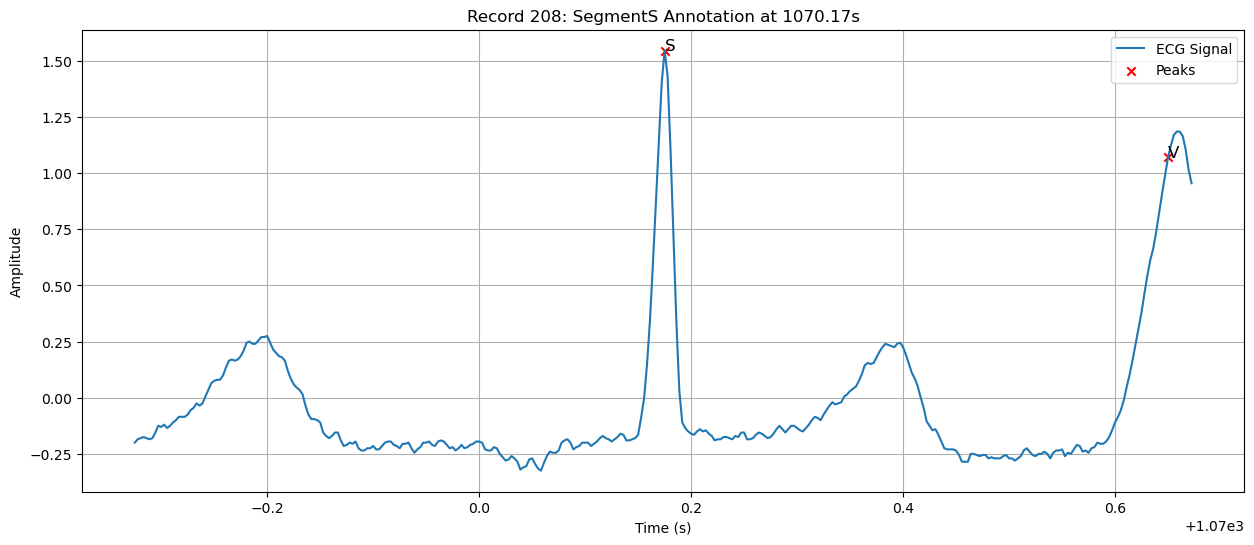

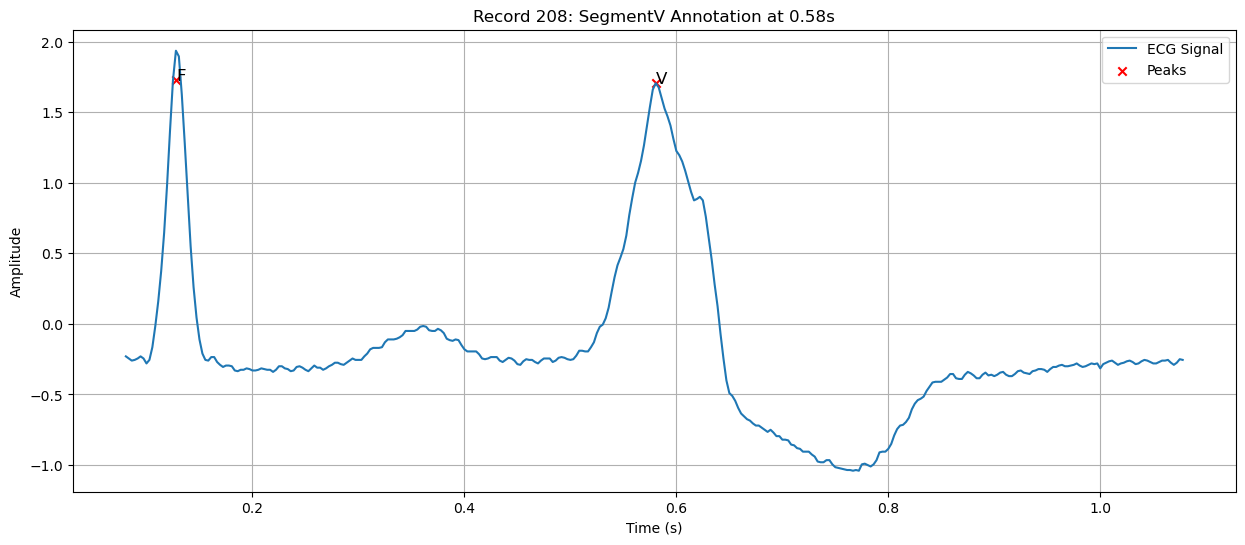

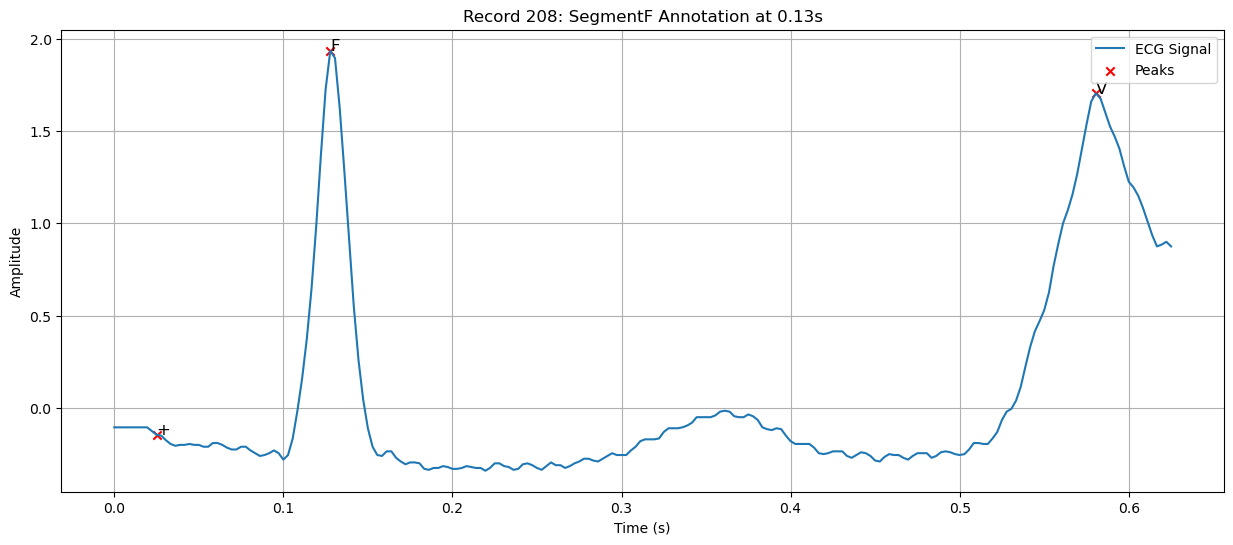

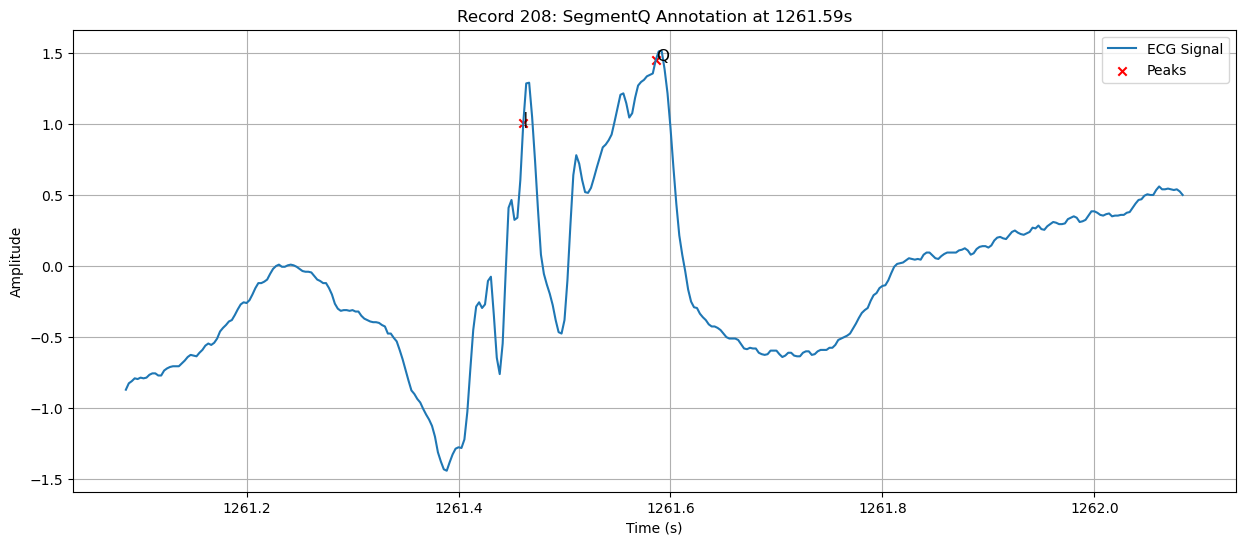

In [39]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# # Load the record and annotations
# record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/203')
# annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/203', 'atr')

# Sampling frequency
fs = record.fs

# Define the labels of interest
labels_of_interest = ['N', 'S', 'V', 'F', 'Q']

# Initialize a dictionary to store sample positions of each label
label_positions = {label: None for label in labels_of_interest}

# Find the first occurrence of each label
for idx, symbol in enumerate(annotation.symbol):
    if symbol in labels_of_interest and label_positions[symbol] is None:
        label_positions[symbol] = annotation.sample[idx]

# Plot the signal around each label and add the annotation marker
for label, sample_position in label_positions.items():
    if sample_position is not None:
        # Define the segment around the annotation
        start_idx = max(sample_position - 180, 0)
        end_idx = min(sample_position + 180, len(record.p_signal))
        signal_segment = record.p_signal[start_idx:end_idx, 0]  # First channel
        time_segment = np.arange(start_idx, end_idx) / fs

        # Extract peaks and annotations within the segment
        peaks = [s for s in annotation.sample if start_idx <= s < end_idx]
        peak_times = [s / fs for s in peaks]
        peak_annotations = [annotation.symbol[np.where(annotation.sample == s)[0][0]] for s in peaks]

        # Align signal values with peak times for display
        arrhythmia_signal_values = [signal_segment[int((t - time_segment[0]) * fs)] for t in peak_times]

        # Plotting
        plt.figure(figsize=(15, 6))
        plt.plot(time_segment, signal_segment, label='ECG Signal')

        # Mark the peaks and annotations
        plt.scatter(peak_times, arrhythmia_signal_values, color='red', marker='x', label='Peaks')

        # Display the annotations on the plot
        for t, annot in zip(peak_times, peak_annotations):
            plt.text(t, signal_segment[int((t - time_segment[0]) * fs)], annot, color='black', fontsize=12)

        plt.title(f'Record 208: Segment{label} Annotation at {sample_position/fs:.2f}s')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print(f"Label '{label}' not found in this record.")


In [2]:
import wfdb

# 데이터 파일 경로
record_path = 'data/100'

# 헤더 파일 읽기
record = wfdb.rdrecord(record_path)

# 헤더 정보 출력
print("Record name:", record.record_name)
print("Number of signals:", record.n_sig)
print("Sampling frequency:", record.fs, "Hz")
print("Counter frequency:", record.counter_freq)
print("Base counter value:", record.base_counter)
print("Sig name:", record.sig_name)
print("P signal:", record.p_signal)
print("D signal:", record.d_signal)
print("Units:", record.units)
print("ADC resolution:", record.adc_res)
print("ADC zero:", record.adc_zero)
print("Baseline:", record.baseline)
print("Gain:", record.adc_gain)
print("Initial value:", record.init_value)
print("Checksum:", record.checksum)
print("Block size:", record.block_size)
print("Comments:", record.comments)


Record name: 100
Number of signals: 2
Sampling frequency: 360 Hz
Counter frequency: None
Base counter value: None
Sig name: ['MLII', 'V5']
P signal: [[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]
D signal: None
Units: ['mV', 'mV']
ADC resolution: [11, 11]
ADC zero: [1024, 1024]
Baseline: [1024, 1024]
Gain: [200.0, 200.0]
Initial value: [995, 1011]
Checksum: [-22131, 20052]
Block size: [0, 0]
Comments: ['69 M 1085 1629 x1', 'Aldomet, Inderal']


In [3]:
import wfdb

# 데이터 파일 경로
record_path = 'data/100'

# 주석 데이터 읽기
annotation = wfdb.rdann(record_path, 'atr')

# 주석의 샘플 위치와 주석 코드 출력
for i in range(len(annotation.sample)):
    print(f'Sample: {annotation.sample[i]}, Annotation: {annotation.symbol[i]}')


Sample: 18, Annotation: +
Sample: 77, Annotation: N
Sample: 370, Annotation: N
Sample: 662, Annotation: N
Sample: 946, Annotation: N
Sample: 1231, Annotation: N
Sample: 1515, Annotation: N
Sample: 1809, Annotation: N
Sample: 2044, Annotation: A
Sample: 2402, Annotation: N
Sample: 2706, Annotation: N
Sample: 2998, Annotation: N
Sample: 3282, Annotation: N
Sample: 3560, Annotation: N
Sample: 3862, Annotation: N
Sample: 4170, Annotation: N
Sample: 4466, Annotation: N
Sample: 4764, Annotation: N
Sample: 5060, Annotation: N
Sample: 5346, Annotation: N
Sample: 5633, Annotation: N
Sample: 5918, Annotation: N
Sample: 6214, Annotation: N
Sample: 6527, Annotation: N
Sample: 6823, Annotation: N
Sample: 7106, Annotation: N
Sample: 7391, Annotation: N
Sample: 7670, Annotation: N
Sample: 7953, Annotation: N
Sample: 8245, Annotation: N
Sample: 8539, Annotation: N
Sample: 8837, Annotation: N
Sample: 9141, Annotation: N
Sample: 9431, Annotation: N
Sample: 9710, Annotation: N
Sample: 9998, Annotation: N

데이터 확인
채널이 (650000,2)로 2개가 존재하는데 LEAD 1과 LEAD 2로 LEAD2를 사용 예정

In [4]:
import wfdb

# 데이터 파일 경로
record_path = 'data/100'

# 신호 데이터(.dat)와 헤더(.hea) 파일 읽기
record = wfdb.rdrecord(record_path)

# 신호 데이터 출력
signal = record.p_signal

print("Signal shape:", signal.shape)
print("First 10 data points of the first channel:", signal[:10, 0])


Signal shape: (650000, 2)
First 10 data points of the first channel: [-0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.12  -0.135]


데이터가 잘 불러와졌는지 그래프로 확인
signal데이터에 atr peak annotation데이터 표시

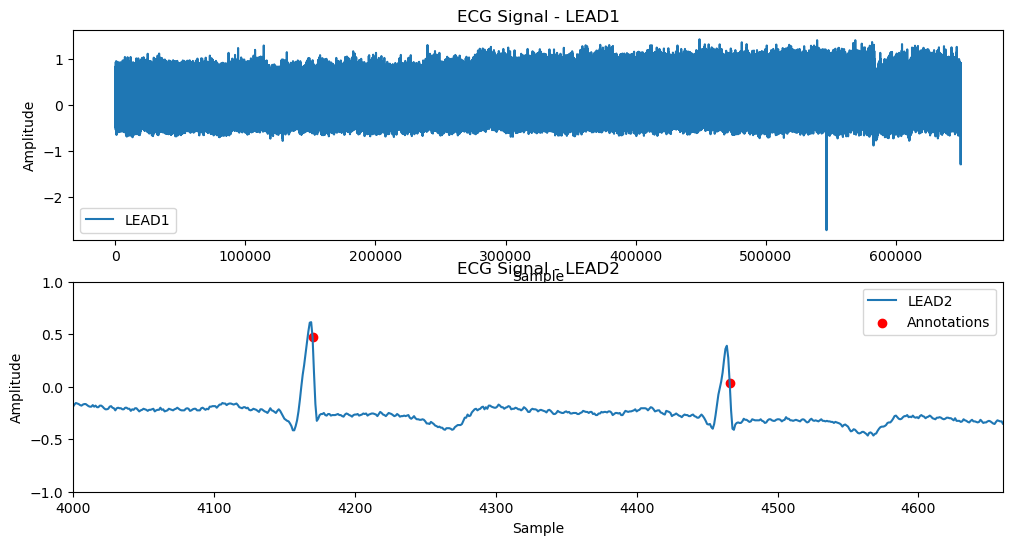

In [5]:
import matplotlib.pyplot as plt

lead1 = signal[:, 0]
lead2 = signal[:, 1]

# 플로팅
plt.figure(figsize=(12, 6))

# LEAD1 데이터 플로팅
plt.subplot(2, 1, 1)
plt.plot(lead1, label='LEAD1')
plt.title('ECG Signal - LEAD1')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

# LEAD2 데이터 플로팅
plt.subplot(2, 1, 2)
plt.plot(lead2, label='LEAD2')
plt.title('ECG Signal - LEAD2')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

# atr데이터 표시 (peak 표시)
plt.scatter(annotation.sample, lead2[annotation.sample], color='red', marker='o', label='Annotations')
plt.legend()

plt.ylim(-1,1)
plt.xlim(4000,4660)
# plt.tight_layout()
plt.show()

peak위치가 조금 이상한 듯 싶음...


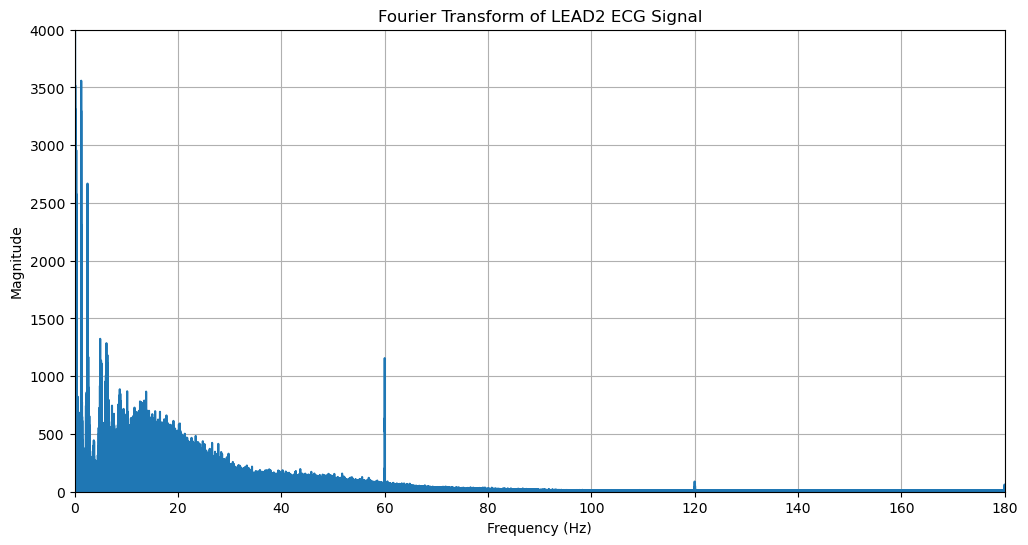

In [6]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# 데이터 파일 경로
record_path = 'data/100'

# 신호 데이터(.dat)와 헤더(.hea) 파일 읽기
record = wfdb.rdrecord(record_path)

# LEAD2 데이터
lead2 = record.p_signal[:, 1]

# 푸리에 변환
fft_lead2 = np.fft.fft(lead2)
fft_freqs = np.fft.fftfreq(len(lead2), d=1/360)

# 푸리에 변환 결과의 절대값 취하기 (주파수 스펙트럼)
fft_magnitude = np.abs(fft_lead2)

# 주파수 도메인에서의 LEAD2 데이터 시각화
plt.figure(figsize=(12, 6))

plt.plot(fft_freqs, fft_magnitude)
plt.title('Fourier Transform of LEAD2 ECG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,180)
plt.ylim(0,4000)
plt.grid()

plt.show()


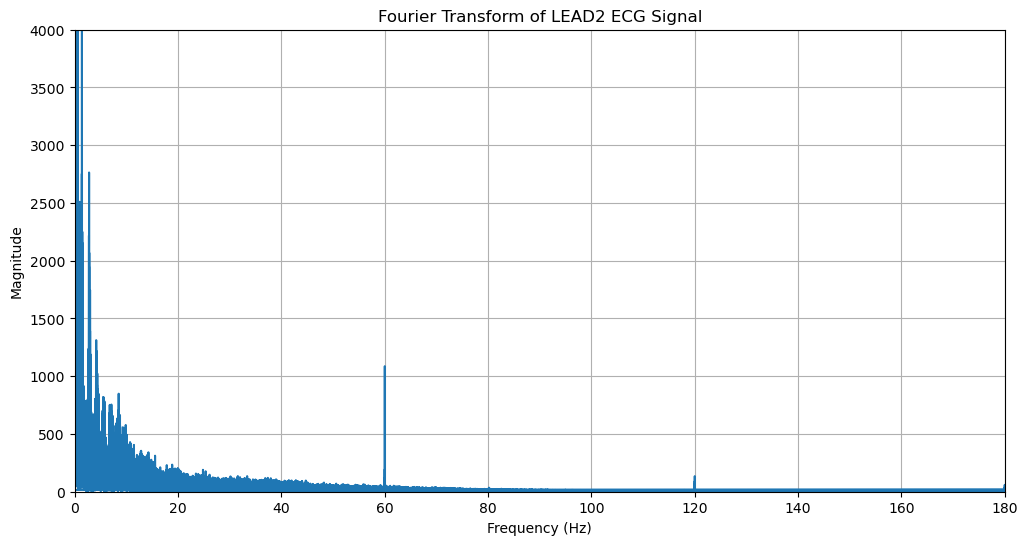

In [7]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# 데이터 파일 경로
record_path = 'data/105'

# 신호 데이터(.dat)와 헤더(.hea) 파일 읽기
record = wfdb.rdrecord(record_path)

# LEAD2 데이터
lead2 = record.p_signal[:, 1]

# 푸리에 변환
fft_lead2 = np.fft.fft(lead2)
fft_freqs = np.fft.fftfreq(len(lead2), d=1/360)

# 푸리에 변환 결과의 절대값 취하기 (주파수 스펙트럼)
fft_magnitude = np.abs(fft_lead2)

# 주파수 도메인에서의 LEAD2 데이터 시각화
plt.figure(figsize=(12, 6))

plt.plot(fft_freqs, fft_magnitude)
plt.title('Fourier Transform of LEAD2 ECG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,180)
plt.ylim(0,4000)
plt.grid()

plt.show()


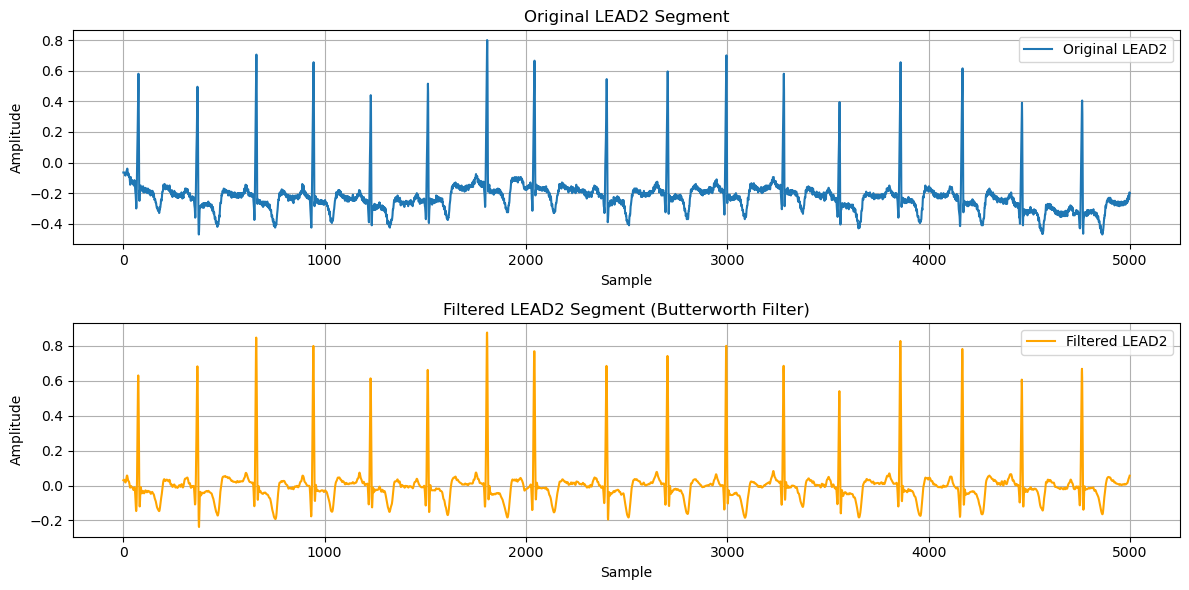

In [8]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 데이터 파일 경로
record_path = 'data/100'

# 신호 데이터(.dat)와 헤더(.hea) 파일 읽기
record = wfdb.rdrecord(record_path)

# LEAD2 데이터
lead2 = record.p_signal[:, 1]

# 샘플링 주파수
fs = record.fs

# Butterworth 필터 설계
def butterworth_filter(data, cutoff, fs, order=5, btype='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, data)
    return y

# 필터 적용 (예: 0.5 - 40 Hz 대역통과 필터)
lowcut = 0.5
highcut = 40.0
order = 4

# 대역통과 필터 설계 및 적용
b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
filtered_lead2 = filtfilt(b, a, lead2)

# 데이터의 일부 선택 (예: 첫 5000 샘플)
sample_range = 5000
lead2_segment = lead2[:sample_range]
filtered_segment = filtered_lead2[:sample_range]

# 원본 데이터와 필터링된 데이터 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(lead2_segment, label='Original LEAD2')
plt.title('Original LEAD2 Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(filtered_segment, label='Filtered LEAD2', color='orange')
plt.title('Filtered LEAD2 Segment (Butterworth Filter)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


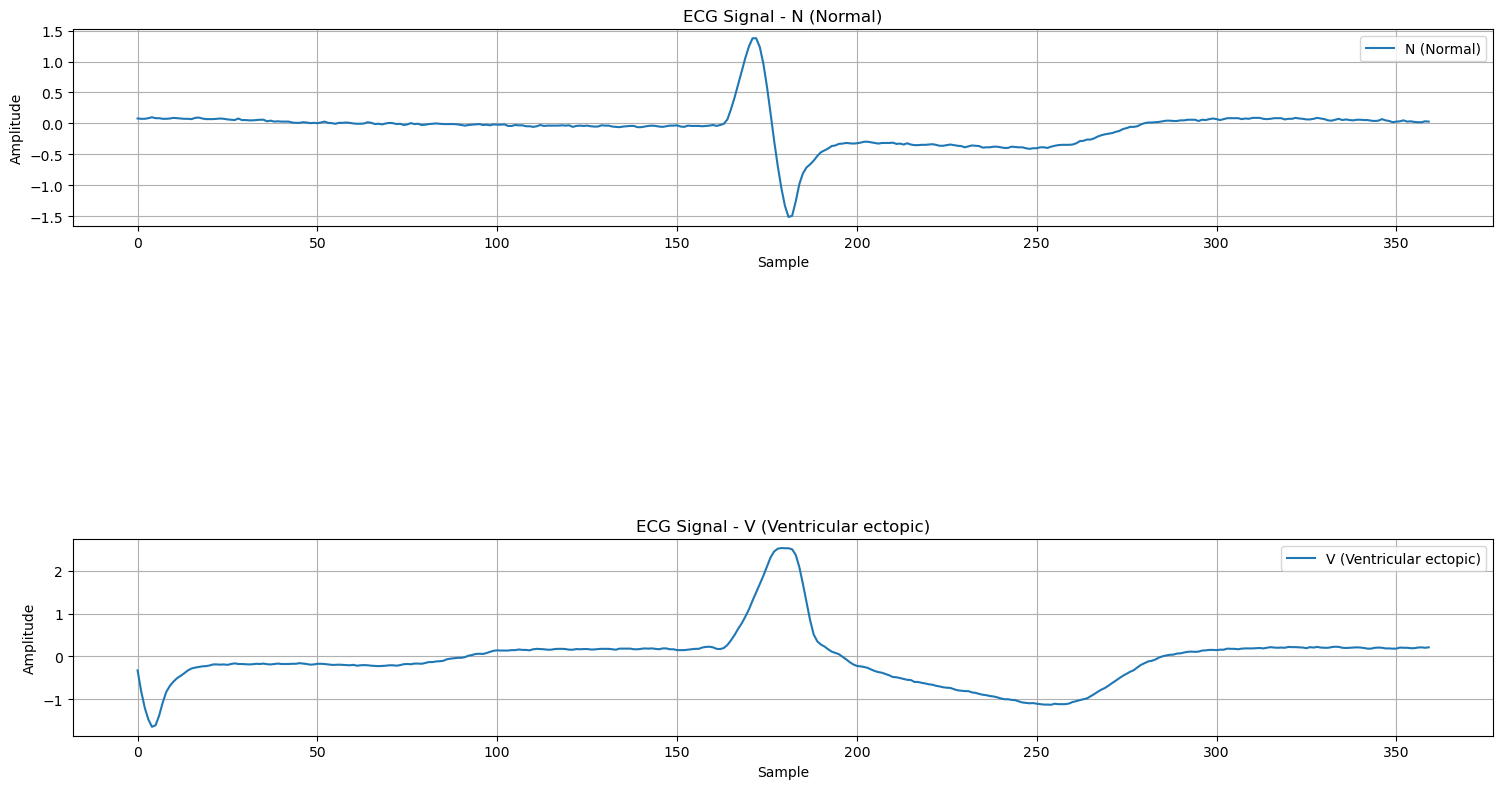

In [9]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# 데이터 파일 경로
record_path = 'data/102'

# 신호 데이터(.dat)와 헤더(.hea) 파일 읽기
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

# LEAD2 데이터
lead2 = record.p_signal[:, 1]

# 주석 위치와 주석 코드
ann_samples = annotation.sample
ann_symbols = annotation.symbol

# 주석 유형에 따라 신호를 분류
n_indices = [i for i, sym in enumerate(ann_symbols) if sym == 'N']
s_indices = [i for i, sym in enumerate(ann_symbols) if sym == 'S']
v_indices = [i for i, sym in enumerate(ann_symbols) if sym == 'V']

# 주석 위치에서 일정 범위의 신호를 추출
def extract_signal_segment(signal, index, window_size=360):
    start = max(0, index - window_size // 2)
    end = min(len(signal), index + window_size // 2)
    return signal[start:end]

# 플로팅
plt.figure(figsize=(15, 8))

# 각 주석 유형에서 첫 번째 신호 추출 및 플로팅
if n_indices:
    n_signal = extract_signal_segment(lead2, ann_samples[n_indices[0]])
    plt.subplot(3, 1, 1)
    plt.plot(n_signal, label='N (Normal)')
    plt.title('ECG Signal - N (Normal)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

if s_indices:
    s_signal = extract_signal_segment(lead2, ann_samples[s_indices[0]])
    plt.subplot(3, 1, 2)
    plt.plot(s_signal, label='S (Supraventricular ectopic)')
    plt.title('ECG Signal - S (Supraventricular ectopic)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

if v_indices:
    v_signal = extract_signal_segment(lead2, ann_samples[v_indices[0]])
    plt.subplot(3, 1, 3)
    plt.plot(v_signal, label='V (Ventricular ectopic)')
    plt.title('ECG Signal - V (Ventricular ectopic)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
